In [1]:
import lcdb

In [2]:
curves = lcdb.get_all_curves()
curves

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508
...,...,...,...,...,...,...,...,...,...,...
1953366,1464,sklearn.linear_model.SGDClassifier,181,75,4,4,0.0010,0.8011,0.7647,0.7600
1953367,1464,sklearn.linear_model.SGDClassifier,256,75,4,4,0.0012,0.7734,0.7647,0.7600
1953368,1464,sklearn.linear_model.SGDClassifier,362,75,4,4,0.0015,0.7735,0.7647,0.7600
1953369,1464,sklearn.linear_model.SGDClassifier,512,75,4,4,0.0018,0.4395,0.3676,0.4533


In [3]:
curves

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508
...,...,...,...,...,...,...,...,...,...,...
1953366,1464,sklearn.linear_model.SGDClassifier,181,75,4,4,0.0010,0.8011,0.7647,0.7600
1953367,1464,sklearn.linear_model.SGDClassifier,256,75,4,4,0.0012,0.7734,0.7647,0.7600
1953368,1464,sklearn.linear_model.SGDClassifier,362,75,4,4,0.0015,0.7735,0.7647,0.7600
1953369,1464,sklearn.linear_model.SGDClassifier,512,75,4,4,0.0018,0.4395,0.3676,0.4533


In [76]:
import torch

def vapor_pressure(x, a, b, c):
    return torch.exp(a + b * x + c * torch.log(x + 1))

def pow3(x, a, alpha, c):
    return c - a * torch.pow(x, -alpha)

def log_log_linear(x, a, b):
    a = torch.clip(a, 1e-6)
    b = torch.clip(b, 1e-6)
    return torch.log(a * torch.log(x + 1) + b)

def hill3(x, alpha, beta, kappa, delta):
    kappa = torch.clip(kappa, 1e-6)
    delta = torch.clip(delta, 1e-6)
    return alpha - beta / (alpha - 1 + torch.pow(kappa * x, delta))

def log_power(x, a, c):
    return c - torch.pow(torch.log(x + 1), a)

def pow4(x, a, b, alpha, c):
    a = torch.clip(a, 1e-6)
    b = torch.clip(b, 1e-6)
    return c - torch.pow(a * x + b, -alpha)

def mmf(x, alpha, beta, kappa, delta):
    delta = torch.clip(delta, 1e-6)
    kappa = torch.clip(kappa, 1e-6)
    return alpha - beta / (alpha - 1 + torch.pow(kappa * x, delta))

def exp4(x, a, b, c):
    return c - torch.exp(-a * x + b)

def janoschek(x, alpha, beta, kappa):
    return alpha - (alpha - beta) * torch.exp(-kappa * x)

def weibull(x, alpha, beta, kappa, delta):
    delta = torch.clamp(delta, 1e-6)
    kappa = torch.clip(kappa, 1e-6)
    return alpha - (alpha - beta) * torch.exp(-torch.pow(kappa * x, delta))

def ilog2(x, a, c):
    return c - torch.pow(torch.log(x + 1), a)

In [141]:
model_dict = {
    vapor_pressure: 3,
    pow3: 3,
    log_log_linear: 2,
    hill3: 4,
    log_power: 2,
    pow4: 4,
    mmf: 4,
    exp4: 3,
    janoschek: 3,
    weibull: 4,
    ilog2: 2
}

def combined(x, original_weights, theta):
    x = x.reshape((x.shape[1], x.shape[0]))
    y = torch.zeros_like(x)

    start_idx = 0
    for model, num_params in model_dict.items():
        end_idx = start_idx + num_params
        model_params = theta[:, start_idx:end_idx]
        model_params = model_params.reshape((end_idx - start_idx, 1, -1))
        model_params = model_params.repeat((1, x.shape[0], 1))
        out = model(x, *model_params)
        
        weights = original_weights[:, list(model_dict.keys()).index(model)]
        weights = weights.reshape((1, -1))
        weights = weights.repeat((x.shape[0], 1))
        
        y += weights * out
        
        start_idx = end_idx

    return y.reshape((x.shape[1], -1))

def combined_single(x, original_weights, theta):
    y = torch.zeros_like(x)

    start_idx = 0
    for model, num_params in model_dict.items():
        end_idx = start_idx + num_params
        model_params = theta[start_idx:end_idx]
        out = model(x, *model_params)
        if torch.isnan(out).any() or torch.isinf(out).any():
            out = torch.ones_like(out)
        weight = original_weights[list(model_dict.keys()).index(model)]
        y += weight * out
        start_idx = end_idx

    return y

In [142]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

def model(ts, ys=None):
    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(len(model_dict))))

    n_thetas = sum(model_dict.values())
    theta = pyro.sample("theta", dist.Normal(0, 1).expand([n_thetas]).to_event(1))

    std = pyro.sample("std", dist.Exponential(0.5))

    prediction = combined_single(ts, weights, theta)
    with pyro.plate("data", ts.shape[0]):
        pyro.sample("obs", dist.Normal(prediction, std), obs=ys)
    


In [143]:
import lcdb
curve = lcdb.get_curve(3, "sklearn.linear_model.LogisticRegression")
anchors, scores_train, scores_valid, scores_test = curve

x_train = torch.Tensor(anchors)[:-3]
y_train = torch.Tensor(scores_test)[:, 0][:-3]

x_test = torch.Tensor(anchors)[-3:]
y_test = torch.Tensor(scores_test)[:, 0][-3:]

In [144]:
print(x_test, y_test)

tensor([1448., 2048., 2588.]) tensor([0.9719, 0.9750, 0.9781])


In [145]:
from torch import optim
initial_weights = torch.ones(len(model_dict)) / len(model_dict)  # evenly distributed initial weights
initial_std = torch.tensor(0.5)  # initial standard deviation for prediction

def loss_fn(model_output, target):
    return torch.mean((model_output - target)**2)

n_thetas = sum(model_dict.values())
initial_theta = torch.randn(n_thetas, requires_grad=True)  # Random initializatio
while loss_fn(combined_single(x_train, initial_weights, initial_theta), y_train) > len(y_train):
    initial_theta = torch.randn(n_thetas, requires_grad=True)  # Random initializatio

# Optimizer
optimizer = optim.Adam([initial_theta], lr=1e-4)

# Optimization loop
num_steps = 6000  # Number of optimization steps
for step in range(num_steps):
    optimizer.zero_grad()
    model_output = combined_single(x_train, initial_weights, initial_theta)
    loss = loss_fn(model_output, y_train)
    loss.backward()
    optimizer.step()
    if step % 2000 == 1999:
        print(f"Step {step}: Loss = {loss.item()}")

initial_theta = initial_theta.detach()

Step 1999: Loss = 0.020806046202778816
Step 3999: Loss = 0.001298145274631679
Step 5999: Loss = 0.0011624121107161045
Step 7999: Loss = 0.0011244491906836629
Step 9999: Loss = 0.0010911277495324612


In [146]:
initial_params = {
    "weights": torch.ones(10) / 10,
    "theta": initial_theta,
    "std": initial_std
}

In [147]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=100, initial_params=initial_params)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 200/200 [06:19,  1.90s/it, step size=4.49e-04, acc. prob=0.775]


In [148]:
mcmc.get_samples()

{'std': tensor([0.0359, 0.0367, 0.0329, 0.0264, 0.0258, 0.0259, 0.0265, 0.0254, 0.0253,
         0.0195, 0.0201, 0.0205, 0.0208, 0.0192, 0.0217, 0.0178, 0.0177, 0.0180,
         0.0179, 0.0177, 0.0177, 0.0174, 0.0174, 0.0168, 0.0169, 0.0174, 0.0174,
         0.0174, 0.0174, 0.0174, 0.0175, 0.0175, 0.0175, 0.0175, 0.0172, 0.0174,
         0.0174, 0.0174, 0.0174, 0.0181, 0.0178, 0.0185, 0.0188, 0.0227, 0.0200,
         0.0201, 0.0207, 0.0191, 0.0212, 0.0197, 0.0210, 0.0183, 0.0200, 0.0167,
         0.0183, 0.0179, 0.0169, 0.0165, 0.0185, 0.0197, 0.0205, 0.0185, 0.0188,
         0.0149, 0.0154, 0.0158, 0.0191, 0.0164, 0.0154, 0.0162, 0.0218, 0.0224,
         0.0230, 0.0227, 0.0301, 0.0264, 0.0263, 0.0240, 0.0211, 0.0196, 0.0191,
         0.0206, 0.0209, 0.0201, 0.0215, 0.0212, 0.0202, 0.0180, 0.0169, 0.0160,
         0.0186, 0.0206, 0.0158, 0.0121, 0.0140, 0.0167, 0.0160, 0.0162, 0.0177,
         0.0160]),
 'theta': tensor([[ 0.7958, -1.5066, -0.2617,  ..., -0.1468, -0.5020, -0.1369],
   

In [159]:
samples = mcmc.get_samples()
samples

{'std': tensor([0.0359, 0.0367, 0.0329, 0.0264, 0.0258, 0.0259, 0.0265, 0.0254, 0.0253,
         0.0195, 0.0201, 0.0205, 0.0208, 0.0192, 0.0217, 0.0178, 0.0177, 0.0180,
         0.0179, 0.0177, 0.0177, 0.0174, 0.0174, 0.0168, 0.0169, 0.0174, 0.0174,
         0.0174, 0.0174, 0.0174, 0.0175, 0.0175, 0.0175, 0.0175, 0.0172, 0.0174,
         0.0174, 0.0174, 0.0174, 0.0181, 0.0178, 0.0185, 0.0188, 0.0227, 0.0200,
         0.0201, 0.0207, 0.0191, 0.0212, 0.0197, 0.0210, 0.0183, 0.0200, 0.0167,
         0.0183, 0.0179, 0.0169, 0.0165, 0.0185, 0.0197, 0.0205, 0.0185, 0.0188,
         0.0149, 0.0154, 0.0158, 0.0191, 0.0164, 0.0154, 0.0162, 0.0218, 0.0224,
         0.0230, 0.0227, 0.0301, 0.0264, 0.0263, 0.0240, 0.0211, 0.0196, 0.0191,
         0.0206, 0.0209, 0.0201, 0.0215, 0.0212, 0.0202, 0.0180, 0.0169, 0.0160,
         0.0186, 0.0206, 0.0158, 0.0121, 0.0140, 0.0167, 0.0160, 0.0162, 0.0177,
         0.0160]),
 'theta': tensor([[ 0.7958, -1.5066, -0.2617,  ..., -0.1468, -0.5020, -0.1369],
   

tensor([  16.,   23.,   32.,   45.,   64.,   91.,  128.,  181.,  256.,  362.,
         512.,  724., 1024.]) tensor([0.6453, 0.7195, 0.7713, 0.8127, 0.8455, 0.8707, 0.8894, 0.9041, 0.9155,
        0.9242, 0.9309, 0.9362, 0.9402])
tensor([  16.,   23.,   32.,   45.,   64.,   91.,  128.,  181.,  256.,  362.,
         512.,  724., 1024.]) tensor([0.6778, 0.7496, 0.8000, 0.8405, 0.8727, 0.8975, 0.9161, 0.9307, 0.9420,
        0.9508, 0.9576, 0.9629, 0.9671])
tensor([  16.,   23.,   32.,   45.,   64.,   91.,  128.,  181.,  256.,  362.,
         512.,  724., 1024.]) tensor([0.6396, 0.7367, 0.7993, 0.8455, 0.8794, 0.9033, 0.9198, 0.9317, 0.9403,
        0.9464, 0.9507, 0.9539, 0.9562])
tensor([  16.,   23.,   32.,   45.,   64.,   91.,  128.,  181.,  256.,  362.,
         512.,  724., 1024.]) tensor([0.6638, 0.7437, 0.7983, 0.8411, 0.8745, 0.8995, 0.9179, 0.9321, 0.9430,
        0.9512, 0.9576, 0.9626, 0.9664])
tensor([  16.,   23.,   32.,   45.,   64.,   91.,  128.,  181.,  256.,  362.,
      

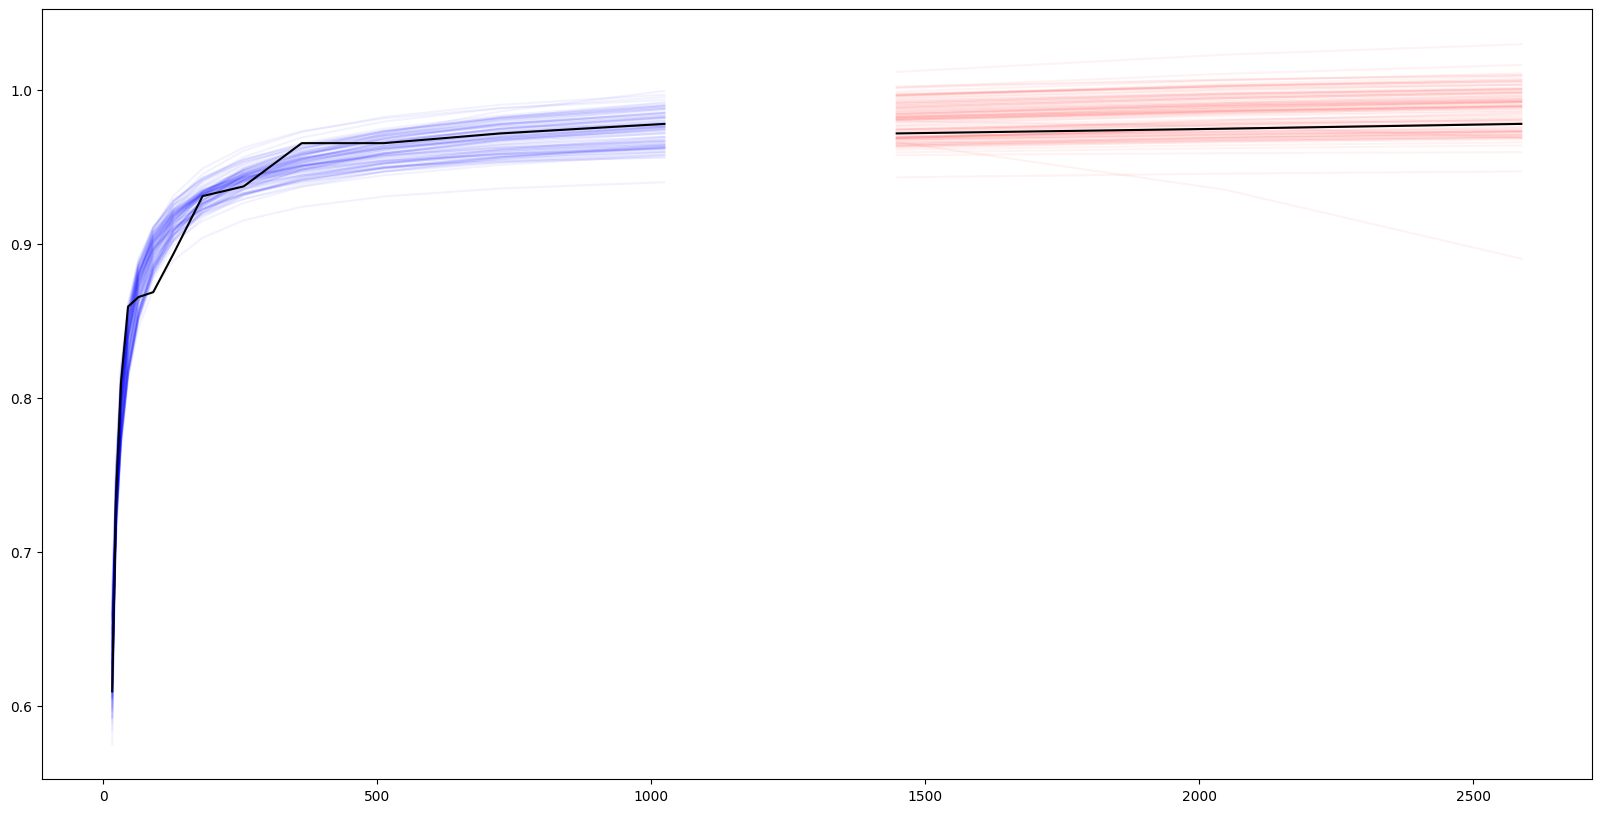

In [161]:
from matplotlib import pyplot as plt
weights = samples["weights"]
thetas = samples["theta"]

plt.figure(figsize=(20, 10))
for i in range(100):
    fitted = combined_single(x_train, weights[i], thetas[i])
    pred = combined_single(x_test, weights[i], thetas[i])
    print(x_train, fitted)
    alpha = 0.05
    plt.plot(x_train, fitted, 'b', alpha=alpha)
    plt.plot(x_test, pred, 'r', alpha=alpha)
    
plt.plot(x_train, y_train, 'k')
plt.plot(x_test, y_test, 'k')